<a href="https://colab.research.google.com/github/brianchinphd/SynPUFCostAnalysis/blob/main/BrianChin_SynPUF_HighCostOutpatientAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brian Chin — SynPUF High-Cost Outpatient Analysis


This notebook explores high-cost outpatient claims using CMS Synthetic Public Use Files (Sample 13, 2008–2010).  
Goals:
- Join beneficiary and outpatient data on `DESYNPUF_ID`
- Examine cost distributions and identify top cost drivers
- Summarize clinical categories underlying the costliest claims

# Import Libraries and Excel Data

We start by importing standard Python libraries for data manipulation (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`).

In [3]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#Load in the relevant datasets and assign them names for easier coding
#FileNotFoundError? Remember to reupload the CSV.
bene = pd.read_csv('/content/DE1_0_2008_Beneficiary_Summary_File_Sample_13.csv')
outpt = pd.read_csv('/content/DE1_0_2008_to_2010_Outpatient_Claims_Sample_13.csv')

/tmp/ipython-input-3081300438.py:4: DtypeWarning: Columns (21,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  outpt = pd.read_csv('/content/DE1_0_2008_to_2010_Outpatient_Claims_Sample_13.csv')


In [8]:
#Inspect each of these tables (datasets)
bene.info()
outpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116363 entries, 0 to 116362
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DESYNPUF_ID               116363 non-null  object 
 1   BENE_BIRTH_DT             116363 non-null  int64  
 2   BENE_DEATH_DT             1852 non-null    float64
 3   BENE_SEX_IDENT_CD         116363 non-null  int64  
 4   BENE_RACE_CD              116363 non-null  int64  
 5   BENE_ESRD_IND             116363 non-null  object 
 6   SP_STATE_CODE             116363 non-null  int64  
 7   BENE_COUNTY_CD            116363 non-null  int64  
 8   BENE_HI_CVRAGE_TOT_MONS   116363 non-null  int64  
 9   BENE_SMI_CVRAGE_TOT_MONS  116363 non-null  int64  
 10  BENE_HMO_CVRAGE_TOT_MONS  116363 non-null  int64  
 11  PLAN_CVRG_MOS_NUM         116363 non-null  int64  
 12  SP_ALZHDMTA               116363 non-null  int64  
 13  SP_CHF                    116363 non-null  i

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'NCH_BENE_PTB_DDCTBL_AMT',
       'NCH_BENE_PTB_COINSRNC_AMT', 'ADMTNG_ICD9_DGNS_CD', 'HCPCS_CD_1',
       'HCPCS_CD_2', 'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6',
       'HCPCS_CD_7', 'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11',
       'HCPCS_CD_12', 'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15',
       'HCPCS_CD_16', 'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19',
       'HCPCS_CD_20', 'HCPCS_CD_21', 'HCPCS_CD_22', 'HC

In [19]:
#Check out variables in each table
bene.columns
outpt.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'NCH_BENE_PTB_DDCTBL_AMT',
       'NCH_BENE_PTB_COINSRNC_AMT', 'ADMTNG_ICD9_DGNS_CD', 'HCPCS_CD_1',
       'HCPCS_CD_2', 'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6',
       'HCPCS_CD_7', 'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11',
       'HCPCS_CD_12', 'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15',
       'HCPCS_CD_16', 'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19',
       'HCPCS_CD_20', 'HCPCS_CD_21', 'HCPCS_CD_22', 'HC

In [13]:
#Preview the first five rows of the bene table
bene.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,0000BAF51F7D7F01,737982258548627,1,20080707.0,20080707.0,2000RJ,10.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000BAF51F7D7F01,737842258468827,1,20080703.0,20080710.0,4200JS,10.0,0.0,8.186575e+09,8.186575e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000BAF51F7D7F01,737502257984556,1,20080914.0,20080914.0,0507AB,60.0,0.0,3.720887e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000BAF51F7D7F01,737452258061766,1,20081111.0,20081111.0,0506MK,20.0,0.0,6.352417e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000BAF51F7D7F01,737652258582487,1,20081211.0,20081212.0,3613MS,500.0,0.0,7.957708e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Preview the first five rows of the outpt table
outpt.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,0000BAF51F7D7F01,737982258548627,1,20080707.0,20080707.0,2000RJ,10.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000BAF51F7D7F01,737842258468827,1,20080703.0,20080710.0,4200JS,10.0,0.0,8.186575e+09,8.186575e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000BAF51F7D7F01,737502257984556,1,20080914.0,20080914.0,0507AB,60.0,0.0,3.720887e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000BAF51F7D7F01,737452258061766,1,20081111.0,20081111.0,0506MK,20.0,0.0,6.352417e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000BAF51F7D7F01,737652258582487,1,20081211.0,20081212.0,3613MS,500.0,0.0,7.957708e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Join the Data


The key variable `DESYNPUF_ID` uniquely identifies each beneficiary.  
We merge the beneficiary summary file (one row per person) with the outpatient claims file (multiple rows per person) using a left join.

In [16]:
#Merge the datasets based on the CMS join key: "DESYNPUF_ID"

merged = pd.merge(outpt, bene, on='DESYNPUF_ID', how='left')

In [17]:
#Examine the joined dataset

merged.info()
merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790950 entries, 0 to 790949
Columns: 107 entries, DESYNPUF_ID to PPPYMT_CAR
dtypes: float64(22), int64(22), object(63)
memory usage: 645.7+ MB


,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,0000BAF51F7D7F01,737982258548627,1,20080707.0,20080707.0,2000RJ,10.0,0.0,NaN,NaN,...,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
1,0000BAF51F7D7F01,737842258468827,1,20080703.0,20080710.0,4200JS,10.0,0.0,8.186575e+09,8.186575e+09,...,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
2,0000BAF51F7D7F01,737502257984556,1,20080914.0,20080914.0,0507AB,60.0,0.0,3.720887e+09,NaN,...,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
3,0000BAF51F7D7F01,737452258061766,1,20081111.0,20081111.0,0506MK,20.0,0.0,6.352417e+09,NaN,...,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
4,0000BAF51F7D7F01,737652258582487,1,20081211.0,20081212.0,3613MS,500.0,0.0,7.957708e+09,NaN,...,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0


In [20]:
#Quality check the join

print("Before merge:")
print("bene shape:", bene.shape)
print("outpt shape:", outpt.shape)
print("After merge:", merged.shape)


Before merge:
bene shape: (116363, 32)
outpt shape: (790950, 76)
After merge: (790950, 107)


In [21]:
#Test whether each claim event was matched with a beneficiary (this should equal zero)
merged['DESYNPUF_ID'].isna().sum()

np.int64(0)

In [23]:
#Spot-check a single person
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

sample_id = merged['DESYNPUF_ID'].iloc[0]
merged[merged['DESYNPUF_ID'] == sample_id]


,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,ADMTNG_ICD9_DGNS_CD,HCPCS_CD_1,HCPCS_CD_2,HCPCS_CD_3,HCPCS_CD_4,HCPCS_CD_5,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,0000BAF51F7D7F01,737982258548627,1,20080707.0,20080707.0,2000RJ,10.0,0.0,NaN,NaN,NaN,0.0,V5863,V5861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,V5883,85610,99212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
1,0000BAF51F7D7F01,737842258468827,1,20080703.0,20080710.0,4200JS,10.0,0.0,8.186575e+09,8.186575e+09,NaN,0.0,V558,4019,25000,4538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,V5861,P9604,85007,84460,80048,83036,85025,77417,93005,80061,84443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
2,0000BAF51F7D7F01,737502257984556,1,20080914.0,20080914.0,0507AB,60.0,0.0,3.720887e+09,NaN,NaN,0.0,4660,7291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,70.0,NaN,71020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
3,0000BAF51F7D7F01,737452258061766,1,20081111.0,20081111.0,0506MK,20.0,0.0,6.352417e+09,NaN,5.069534e+09,0.0,2520,4011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,NaN,36415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
4,0000BAF51F7D7F01,737652258582487,1,20081211.0,20081212.0,3613MS,500.0,0.0,7.957708e+09,NaN,NaN,0.0,4358,42731,25000,42789,4379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200.0,78079,36415,84520,80053,82607,72125,80061,82728,85610,82553,83721,85025,82131,84460,80053,82570,85018,85610,84443,NaN,82550,85025,85027,80053,82310,82570,86923,85610,80048,81001,85610,85610,85610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
5,0000BAF51F7D7F01,737422258289574,1,20090108.0,20090108.0,0700VV,100.0,0.0,1.354280e+08,NaN,NaN,0.0,49301,5859,4660,V4501,NaN,NaN,NaN,Na

# Describe the Joined Data

In [32]:
# Calculate the claim counts per beneficiary
# Simply, this code is building a condensed dataset by beneficiary and then describing it
claims_per_bene = merged.groupby('DESYNPUF_ID').size().reset_index(name='num_claims')
claims_per_bene['num_claims'].describe()



,num_claims
count,85217.000000
mean,9.281599
std,8.219913
min,1.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,78.000000


In [37]:
# Calculate the mean claim cost (when available)
if 'CLM_PMT_AMT' in merged.columns:
    print(merged['CLM_PMT_AMT'].describe())

count    790950.000000
mean        281.984715
std         568.066268
min        -100.000000
25%          40.000000
50%          80.000000
75%         200.000000
max        3300.000000
Name: CLM_PMT_AMT, dtype: float64


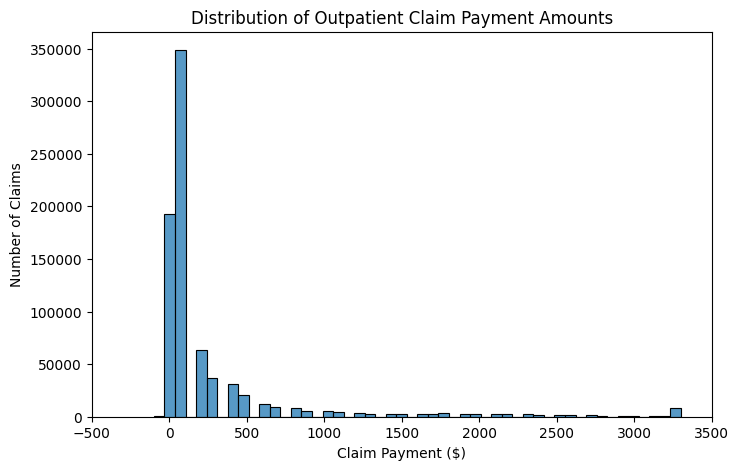

In [74]:
# Visualize the claim cost data to examine skewness

plt.figure(figsize=(8,5))
sns.histplot(merged['CLM_PMT_AMT'], bins=50, edgecolor='black')
plt.title('Distribution of Outpatient Claim Payment Amounts')
plt.xlabel('Claim Payment ($)')
plt.ylabel('Number of Claims')
plt.xlim(-500, 3500)
plt.show()

Visual inspection suggests a strong positive skew with most claims less than 500 USD. I would like to understand the characteristics of the **highest cost cases**, defined as those exceeding claim payment of 3000 USD.

In [41]:
# This code will identify the highest cost cases and subset them into a new dataset.

# define threshold
high_cost_threshold = 3000

# subset
high_cost_claims = merged[merged['CLM_PMT_AMT'] > high_cost_threshold]

# count and describe
print(f"Number of high-cost claims: {len(high_cost_claims):,}")
print(f"Share of total claims: {len(high_cost_claims) / len(merged):.2%}")
print()
print("Descriptive stats for high-cost claims:")
print(high_cost_claims['CLM_PMT_AMT'].describe())


Number of high-cost claims: 9,765
Share of total claims: 1.23%

Descriptive stats for high-cost claims:
count    9765.000000
mean     3279.242192
std        55.561629
min      3100.000000
25%      3300.000000
50%      3300.000000
75%      3300.000000
max      3300.000000
Name: CLM_PMT_AMT, dtype: float64


In [42]:
# Calculate the percent of total cost accounted for by these "high cost claims"
total_paid = merged['CLM_PMT_AMT'].sum()
high_cost_total = high_cost_claims['CLM_PMT_AMT'].sum()
share_of_spending = high_cost_total / total_paid

print(f"High-cost claims (> ${high_cost_threshold:,}) account for "
      f"{share_of_spending:.2%} of total spending.")


High-cost claims (> $3,000) account for 14.36% of total spending.


This shows us that the highest cost claims (> $3,000) account for 14.36% of total spending. Next, let's describe these highest cost claims.

In [47]:
#Create a new table counting and ranking the top diagnoses among highest cost claims
top_diag = (high_cost_claims['ICD9_DGNS_CD_1']
            .value_counts()
            .reset_index()
            .rename(columns={'index': 'Diagnosis_Code', 'ICD9_DGNS_CD_1': 'Count'}))

# Calculate share of high-cost claims
top_diag['Percent'] = 100 * top_diag['count'] / len(high_cost_claims)

# Show top 10
top_diag.head(10)

,Count,count,Percent
0,OTHER,423,4.331797
1,V662,136,1.392729
2,5856,135,1.382488
3,V5631,134,1.372248
4,V672,133,1.362007
5,V5632,125,1.280082
6,V562,124,1.269841
7,V581,123,1.259601
8,V580,122,1.249360
9,V420,120,1.228879


High-cost outpatient claims (> $3,000) were dispersed across post-surgical follow-up, renal-replacement therapy, and oncology treatment encounters. This is consistent with major drivers of outpatient spending in the Medicare population.

In [53]:
# Next, we will categorize individual ICD-9 codes into these broader categories.
def classify_diag(code):
    if pd.isna(code):
        return 'Other'
    code = str(code)
    if code.startswith(('V66', 'V67')):
        return 'Surgery/Recovery'
    elif code.startswith(('585', 'V56')):
        return 'Renal Disease/Dialysis'
    elif code.startswith('V58'):
        return 'Cancer Treatment'
    else:
        return 'Other'

high_cost_claims['Category'] = high_cost_claims['ICD9_DGNS_CD_1'].apply(classify_diag)


driver_summary = (high_cost_claims['Category']
                  .value_counts(normalize=True)
                  .mul(100)
                  .reset_index()
                  .rename(columns={'index':'Category','Category':'Percent_of_HighCost_Claims'}))
driver_summary


,Percent_of_HighCost_Claims,proportion
0,Other,75.883257
1,Renal Disease/Dialysis,14.254992
2,Cancer Treatment,4.976959
3,Surgery/Recovery,4.884793


Next, I summarized diagnostic codes at a broader level.

In [64]:
# Let's start by applying a more detailed categorization system.
def classify_diag_broad(code):
    if pd.isna(code):
        return 'Other'
    code = str(code)
    if code.startswith(('V66','V67')):
        return 'Surgery/Recovery'
    elif code.startswith(('585','V56')):
        return 'Renal Disease/Dialysis'
    elif code.startswith('V58'):
        return 'Cancer Treatment'
    # now some numeric ranges
    elif code[:3].isdigit():
        c = int(code[:3])
        if 140 <= c <= 239:
            return 'Cancer'
        elif 390 <= c <= 459:
            return 'Cardiovascular'
        elif 460 <= c <= 519:
            return 'Respiratory'
        elif 520 <= c <= 579:
            return 'Digestive'
        elif 580 <= c <= 629:
            return 'Genitourinary'
        elif 710 <= c <= 739:
            return 'Musculoskeletal'
        else:
            return 'Other'
    else:
        return 'Other'



In [65]:
# This will generate a table showing the five most common diagnosis categories for the highest cost claims.
merged['ICD9_CAT'] = merged['ICD9_DGNS_CD_1'].astype(str).str[:3]
high_cost_claims['Category'] = high_cost_claims['ICD9_DGNS_CD_1'].apply(classify_diag_broad)
high_cost_claims['Category'].value_counts(normalize=True).mul(100).round(2)
print(high_cost_claims[['ICD9_DGNS_CD_1', 'ICD9_CAT', 'Category']].head())

    ICD9_DGNS_CD_1 ICD9_CAT                Category
102          55329      553               Digestive
122           1624      162                  Cancer
234          73313      733         Musculoskeletal
263          V5632      V56  Renal Disease/Dialysis
561           4333      433          Cardiovascular


In [72]:
# Next, we can show the percent of total cost driven by each of these categories

category_summary = (
    high_cost_claims['Category']
    .value_counts()
    .reset_index()
)

# Rename *after* resetting, when columns are distinct
category_summary.columns = ['Category', 'Claim_Count']

# Now safely compute percentage
category_summary['Percent'] = (
    100 * category_summary['Claim_Count'] / category_summary['Claim_Count'].sum()
)

category_summary


,Category,Claim_Count,Percent
0,Other,3651,37.388633
1,Cardiovascular,1592,16.303123
2,Renal Disease/Dialysis,1392,14.254992
3,Cancer,981,10.046083
4,Musculoskeletal,619,6.338966
5,Cancer Treatment,486,4.976959
6,Surgery/Recovery,477,4.884793
7,Digestive,299,3.061956
8,Genitourinary,179,1.833077
9,Respiratory,89,0.911418


In [73]:
# Here is a cleaner presentation that collapses relevant categories to identify primary cost drives

def simplify_category(cat):
    if cat in ['Renal Disease/Dialysis', 'Cancer', 'Cancer Treatment', 'Cardiovascular']:
        return cat
    else:
        return 'All Other'

category_summary['Collapsed'] = category_summary['Category'].apply(simplify_category)

collapsed = (
    high_cost_claims
    .assign(Collapsed=high_cost_claims['Category'].apply(simplify_category))
    .Collapsed
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
    .rename(columns={'index':'Category','Collapsed':'Percent'})
)
collapsed


,Percent,proportion
0,All Other,54.418843
1,Cardiovascular,16.303123
2,Renal Disease/Dialysis,14.254992
3,Cancer,10.046083
4,Cancer Treatment,4.976959


# Conclusion

**Primary Takeaway: Nearly half of the highest-cost outpatient visits are driven by three types of conditions — cardiovascular disease, renal disease, and cancer (including both direct cancer diagnoses and treatment encounters).**

This notebook demonstrates how to merge, clean, and summarize large-scale healthcare claims data.  
The workflow highlights:
- Proper use of unique patient keys (`DESYNPUF_ID`)
- Validation of one-to-many joins
- Aggregation and visualization of skewed cost data
These steps mirror typical health-analytics pipelines used in payer and population-health settings.  

It also mirrors payer analytics pipelines used to monitor utilization and identify cost drivers in outpatient care.